# Generate UMAP GIF for Token Evolution Progression

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from pathlib import Path
import pickle

from adjustText import adjust_text
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

# Load the data for Observing Change

In [2]:
decade_folder = Path("../word2vec_decade_experiment/output")
aligned_models = pickle.load(
    open(f"{str(decade_folder)}/aligned_word_vectors_2000_2020.pkl", "rb")
)

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (
        list(Path(f"{str(decade_folder)}/year_distances_2005_2020").rglob("*tsv"))
    )
}
list(year_comparison_dict.keys())[0:3]

['2005_2006', '2005_2016', '2005_2019']

In [4]:
year_comparison_dict["2005_2020"].sort_values("global_dist", ascending=False)

,token,local_dist,global_dist,shift
25186,hematophagy,1.773050,1.311658,-0.461392
40728,postage,1.835383,1.305359,-0.530023
5174,67.52,1.921535,1.300695,-0.620840
37325,orthomyxovirus,1.858951,1.295745,-0.563206
22194,finfish,1.759793,1.295375,-0.464418
...,...,...,...,...
8897,are,0.006610,0.129400,0.122790
24934,have,0.010255,0.127731,0.117477
15515,could,0.003141,0.112946,0.109805
32109,may,0.002923,0.102231,0.099308


# Train the UMAP Model

In [5]:
origin_df = aligned_models["2000"]
word_vectors = list(
    map(
        lambda x: x.query(f"token in {origin_df.token.tolist()}")
        .sort_values("token")
        .set_index("token")
        .values,
        aligned_models.values(),
    )
)

In [6]:
word_models_stacked = np.vstack(word_vectors)
file_name = "output/2000_2020_umap_model"

## Neighbors vs Min Distance

In [7]:
n_neighbors = [15, 25]
min_dist = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
years_to_test = [2000, 2005, 2010, 2015, 2020]

In [8]:
for neighbor, min_d in itertools.product(n_neighbors, min_dist):

    if Path(f"output/param_sweep_results/{neighbor}_{min_d}_results.tsv").exists():
        continue

    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=neighbor,
        min_dist=min_d,
    )
    embedding = model.fit_transform(word_models_stacked)
    embedding_model_df = pd.DataFrame(
        {
            "umap1": embedding[:, 0],
            "umap2": embedding[:, 1],
            "year": itertools.chain(
                *list(
                    map(
                        lambda x: aligned_models[x]
                        .query(f"token in {origin_df.token.tolist()}")
                        .sort_values("token")
                        .set_index("token")
                        .assign(year=x)
                        .year.tolist(),
                        aligned_models.keys(),
                    )
                )
            ),
            "token": itertools.chain(
                *list(
                    map(
                        lambda x: x.query(f"token in {origin_df.token.tolist()}")
                        .sort_values("token")
                        .set_index("token")
                        .index.tolist(),
                        aligned_models.values(),
                    )
                )
            ),
        }
    )

    embedding_model_df.to_csv(
        f"output/param_sweep_results/{neighbor}_{min_d}_results.tsv",
        sep="\t",
        index=False,
    )

In [8]:
grid_results = dict()
for file in Path("output/param_sweep_results").rglob("*tsv"):
    grid_results[tuple(file.stem.split("_")[0:2])] = pd.read_csv(str(file), sep="\t")

In [9]:
plot_df = pd.DataFrame(
    [], columns=["umap1", "umap2", "year", "token", "neighbor", "min_d"]
)
for key in grid_results:
    plot_df = plot_df.append(
        grid_results[key]
        .query(f"year in {years_to_test}")
        .groupby("year")
        .apply(lambda x: x.sample(1000, random_state=100))
        .reset_index(drop=True)
        .assign(neighbor=key[0], min_d=key[1])
    )

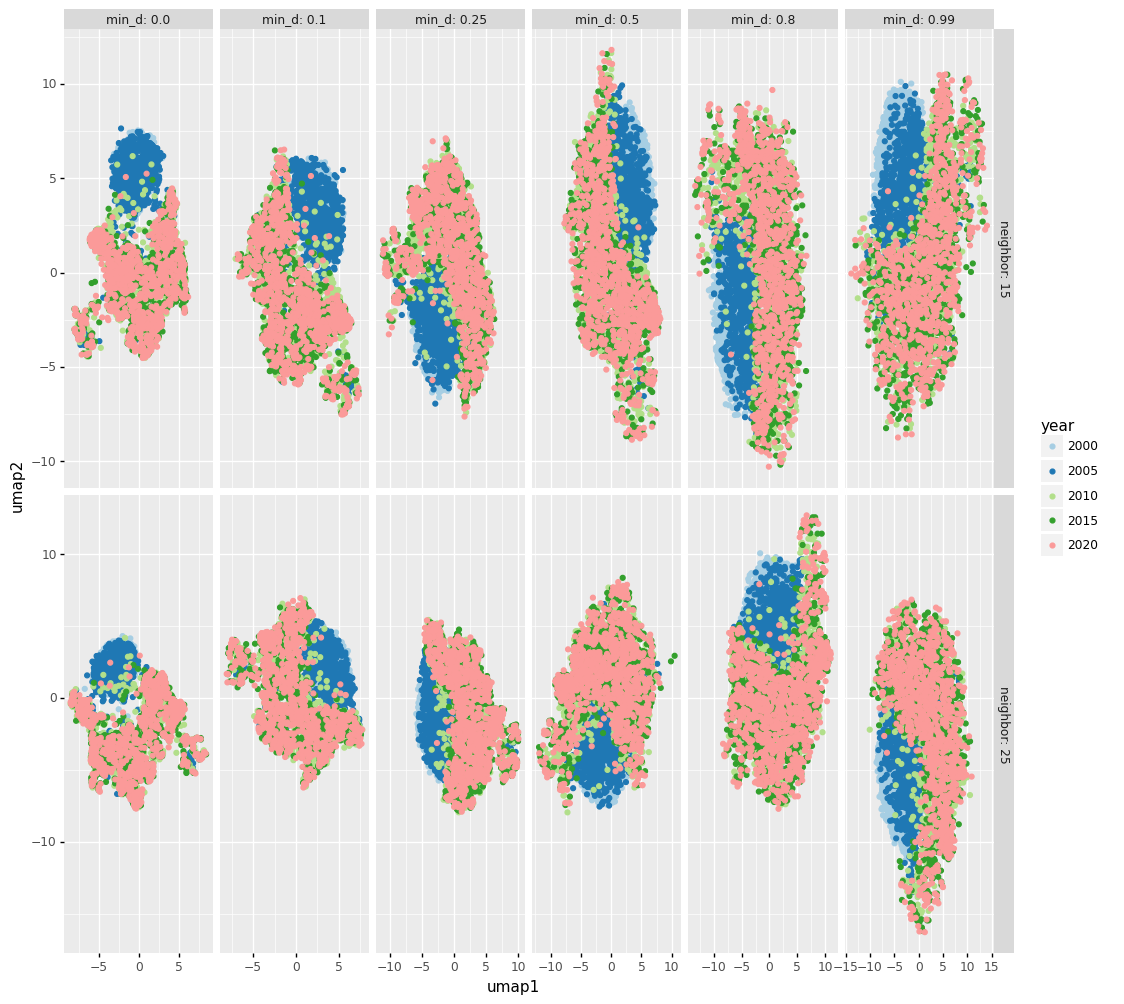

<ggplot: (-9223363299560034679)>


In [10]:
g = (
    p9.ggplot(plot_df, p9.aes(x="umap1", y="umap2", color="year"))
    + p9.geom_point()
    + p9.facet_grid("neighbor ~ min_d", labeller="label_both", scales="free")
    + p9.theme(figure_size=(12, 12))
    + p9.scale_color_brewer(type="qual", palette=3)
)
print(g)

## Epochs Test

In [12]:
n_neighbors = [25]
n_epochs = [2, 3, 5]
min_dist = [0.0]

In [13]:
for neighbor, min_d, epoch in itertools.product(n_neighbors, min_dist, n_epochs):

    if Path(
        f"output/param_sweep_results/{neighbor}_{min_d}_{epoch}_results.tsv"
    ).exists():
        continue

    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=neighbor,
        min_dist=min_d,
        n_training_epochs=epoch,
    )
    embedding = model.fit_transform(word_models_stacked)
    embedding_model_df = pd.DataFrame(
        {
            "umap1": embedding[:, 0],
            "umap2": embedding[:, 1],
            "year": itertools.chain(
                *list(
                    map(
                        lambda x: aligned_models[x]
                        .query(f"token in {origin_df.token.tolist()}")
                        .sort_values("token")
                        .set_index("token")
                        .assign(year=x)
                        .year.tolist(),
                        aligned_models.keys(),
                    )
                )
            ),
            "token": itertools.chain(
                *list(
                    map(
                        lambda x: x.query(f"token in {origin_df.token.tolist()}")
                        .sort_values("token")
                        .set_index("token")
                        .index.tolist(),
                        aligned_models.values(),
                    )
                )
            ),
        }
    )

    embedding_model_df.to_csv(
        f"output/param_sweep_results/{neighbor}_{min_d}_{epoch}_results.tsv",
        sep="\t",
        index=False,
    )

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/umap/parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.


Epoch 1/20
26495/26495 [==============================] - 301s 11ms/step - loss: 0.2384
Epoch 2/20
26495/26495 [==============================] - 299s 11ms/step - loss: 0.1980
Epoch 3/20
26495/26495 [==============================] - 301s 11ms/step - loss: 0.1930
Epoch 4/20
26495/26495 [==============================] - 300s 11ms/step - loss: 0.1909
Epoch 5/20
26495/26495 [==============================] - 299s 11ms/step - loss: 0.1893
Epoch 6/20
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1883
Epoch 7/20
26495/26495 [==============================] - 301s 11ms/step - loss: 0.1874
Epoch 8/20
26495/26495 [==============================] - 300s 11ms/step - loss: 0.1871
Epoch 9/20
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1864
Epoch 10/20
26495/26495 [==============================] - 304s 11ms/step - loss: 0.1860
Epoch 11/20
26495/26495 [==============================] - 300s 11ms/step - loss: 0.1858
Epoch 12/20
26495/26495 [=====

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/umap/parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.


Epoch 1/30
26495/26495 [==============================] - 303s 11ms/step - loss: 0.2369
Epoch 2/30
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1992
Epoch 3/30
26495/26495 [==============================] - 305s 11ms/step - loss: 0.1950
Epoch 4/30
26495/26495 [==============================] - 303s 11ms/step - loss: 0.1927
Epoch 5/30
26495/26495 [==============================] - 306s 12ms/step - loss: 0.1912
Epoch 6/30
26495/26495 [==============================] - 303s 11ms/step - loss: 0.1903
Epoch 7/30
26495/26495 [==============================] - 303s 11ms/step - loss: 0.1895
Epoch 8/30
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1891
Epoch 9/30
26495/26495 [==============================] - 303s 11ms/step - loss: 0.1885
Epoch 10/30
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1881
Epoch 11/30
26495/26495 [==============================] - 302s 11ms/step - loss: 0.1879
Epoch 12/30
26495/26495 [=====

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/umap/parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.


Epoch 1/50
26495/26495 [==============================] - 308s 12ms/step - loss: 0.2382
Epoch 2/50
26495/26495 [==============================] - 308s 12ms/step - loss: 0.1992
Epoch 3/50
26495/26495 [==============================] - 309s 12ms/step - loss: 0.1947
Epoch 4/50
26495/26495 [==============================] - 308s 12ms/step - loss: 0.1926
Epoch 5/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1908
Epoch 6/50
26495/26495 [==============================] - 308s 12ms/step - loss: 0.1900
Epoch 7/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1892
Epoch 8/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1886
Epoch 9/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1881
Epoch 10/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1876
Epoch 11/50
26495/26495 [==============================] - 307s 12ms/step - loss: 0.1872
Epoch 12/50
26495/26495 [=====

In [11]:
grid_results = dict()
for file in Path("output/param_sweep_results").rglob("*tsv"):
    params = file.stem.split("_")[:-1]

    if len(params) < 3:
        continue

    grid_results[tuple(file.stem.split("_")[0:3])] = pd.read_csv(str(file), sep="\t")

In [12]:
plot_df = pd.DataFrame(
    [], columns=["umap1", "umap2", "year", "token", "neighbor", "min_d"]
)
for key in grid_results:
    plot_df = plot_df.append(
        grid_results[key]
        .query(f"year in {years_to_test}")
        .groupby("year")
        .apply(lambda x: x.sample(1000, random_state=100))
        .reset_index(drop=True)
        .assign(neighbor=key[0], min_d=key[1], epoch=key[2])
    )

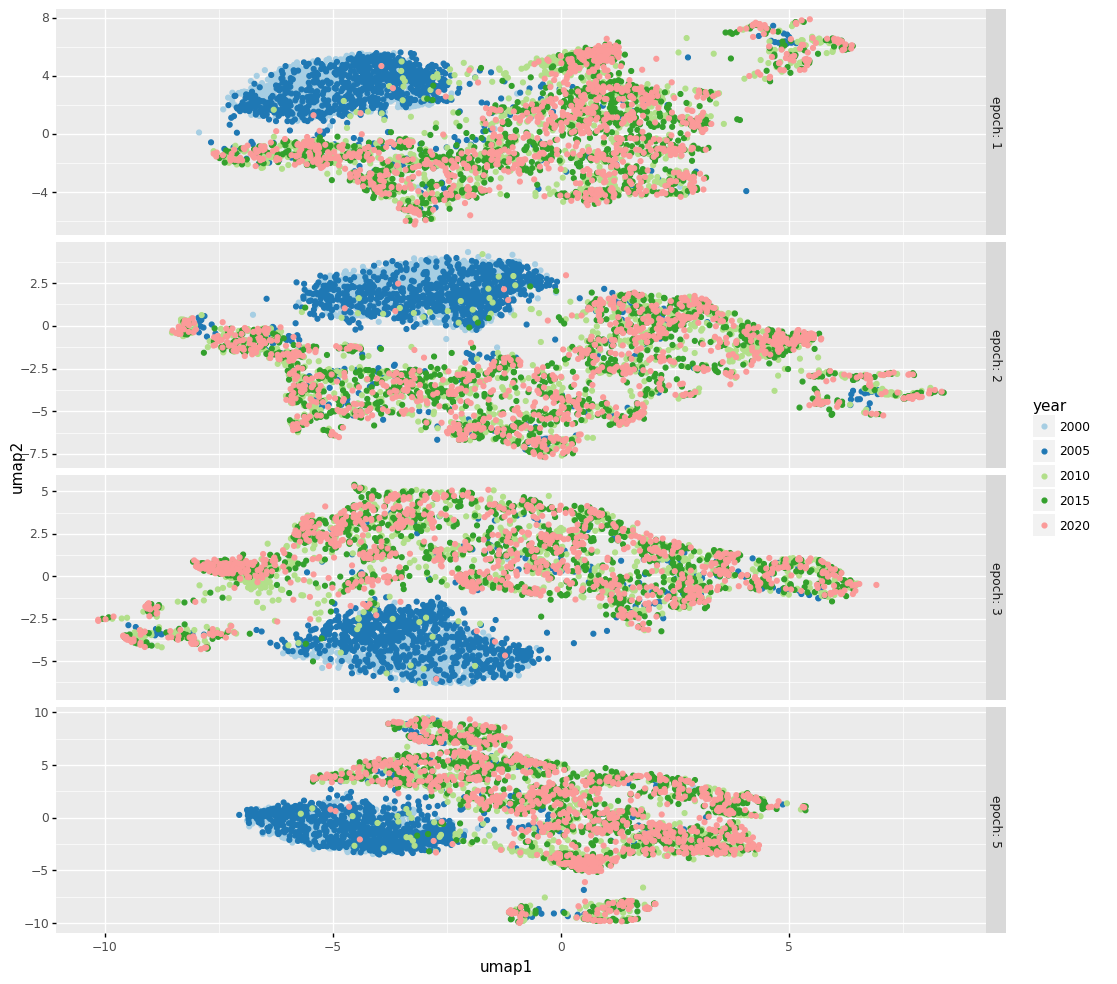

<ggplot: (-9223363298939289007)>


In [13]:
g = (
    p9.ggplot(plot_df, p9.aes(x="umap1", y="umap2", color="year"))
    + p9.geom_point()
    + p9.facet_grid("epoch ~ .", labeller="label_both", scales="free")
    + p9.theme(figure_size=(12, 12))
    + p9.scale_color_brewer(type="qual", palette=3)
)
print(g)